# Artifact 3: Improvement 2
### Monte Carlo Simulation 2: Investigating the Relationship between Build Minutes and Delay

### Part 1: Setup all the functions required

In [30]:
import sys
import logging
import pandas as pd
import numpy as np
from tqdm import tqdm
from google.cloud import bigquery
from collections import defaultdict
import matplotlib.pyplot as plt

client = bigquery.Client()

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger(__name__)


def batch_commits_and_sum_build_times(
    commits: pd.DataFrame, workflow_runs: pd.DataFrame, batch_max_wait_time: int
):
    """
    Given a DataFrame of commits, batch them into groups based on the time between commits
    """
    total_build_time = 0
    total_batches = 0
    total_delay = 0
    current_batch_workflows = defaultdict(list)
    current_batch_end_time = commits.iloc[0]["date"] + pd.Timedelta(
        minutes=batch_max_wait_time
    )

    for i in range(len(commits)):
        curr_commit = commits.iloc[i]

        if curr_commit["date"] > current_batch_end_time:
            for _, build_times in current_batch_workflows.items():
                total_build_time += np.mean(build_times)

            current_batch_end_time = curr_commit["date"] + pd.Timedelta(
                minutes=batch_max_wait_time
            )
            current_batch_workflows = defaultdict(list)
            total_delay += batch_max_wait_time
            total_batches += 1

        workflows_for_commit = workflow_runs.loc[
            workflow_runs["head_sha"] == curr_commit["sha"]
        ]
        for _, workflow in workflows_for_commit.iterrows():
            current_batch_workflows[workflow["workflow_id"]].append(
                workflow["build_minutes"]
            )

    # Process the last batch
    for _, build_times in current_batch_workflows.items():
        total_build_time += np.mean(build_times)
    total_delay += batch_max_wait_time
    total_batches += 1

    return (total_build_time, total_delay, total_delay / total_batches)


def run_monte_carlo_simulation(
    all_commits: pd.DataFrame, workflow_runs: pd.DataFrame, iterations: int = 10
):
    simulation_results = []
    for _ in tqdm(range(iterations)):
        bootstrap_sample = all_commits.sample(
            n=1000, replace=True
        ).sort_index()  # retain original sorted order which which started at the earliest commit in range and is ascending by time

        merge_queue_batch_delay = np.random.randint(1, 61)
        build_time, total_delay, mean_delay = batch_commits_and_sum_build_times(
            bootstrap_sample, workflow_runs, merge_queue_batch_delay
        )

        simulation_results.append(
            {
                "merge_queue_batch_delay": merge_queue_batch_delay,
                "total_ci_minutes": build_time,
                "total_delay": total_delay,
                "mean_delay": mean_delay,
            }
        )

    simulation_results_df = pd.DataFrame(simulation_results)

    return simulation_results_df


def run_control(workflow_runs: pd.DataFrame):
    return workflow_runs["build_minutes"].sum()

### Part 2: Pull the data from BigQuery

In [31]:
query_for_commit_shas = "SELECT sha, commit.committer.date FROM `scientific-glow-417622.beam.commits` ORDER BY commit.committer.date ASC"
query_for_workflow_runs = """
    SELECT
        workflow_run.head_sha,
        workflow_run.name,
        workflow_run.workflow_id,
        workflow_run.run_started_at,
        workflow_run.created_at,
        workflow_run.updated_at,
        TIMESTAMP_DIFF(workflow_run.updated_at, workflow_run.created_at, SECOND) / 60.0 AS build_minutes
    FROM
        `scientific-glow-417622.beam.commits` AS commits
    CROSS JOIN
        `scientific-glow-417622.beam.push_and_schedule_workflows`,
        UNNEST(workflow_runs) AS workflow_run
    WHERE
        commits.sha = workflow_run.head_sha AND workflow_run.event = 'push'
        """
logger.info("Fetching data from BigQuery...")
commits_df = client.query_and_wait(query_for_commit_shas).to_dataframe()
workflow_runs_df = client.query_and_wait(query_for_workflow_runs).to_dataframe()


INFO:__main__:Fetching data from BigQuery...


### Part 3: Run Control and Monte Carlo Simulation

In [32]:
logger.info("Calculating control Build minutes...")
control_build_minutes = run_control(workflow_runs_df)
logger.info(f"Total Build Time for Control is: {control_build_minutes}")
print(control_build_minutes)

INFO:__main__:Calculating control Build minutes...
INFO:__main__:Total Build Time for Control is: 293286.8
293286.8


In [33]:
logger.info("Running Monte Carlo Simulation...")
simulation_results_df = run_monte_carlo_simulation(
    commits_df, workflow_runs_df, iterations=10000
)
print(simulation_results_df)

INFO:__main__:Running Monte Carlo Simulation...


100%|██████████| 10000/10000 [2:13:31<00:00,  1.25it/s] 

      merge_queue_batch_delay  total_ci_minutes  total_delay  mean_delay
0                          23     181587.845966        11270        23.0
1                          44     148007.197712        18788        44.0
2                          21     183338.213824        10542        21.0
3                          12     156025.019444         6456        12.0
4                          12     180731.559722         6444        12.0
...                       ...               ...          ...         ...
9995                       49     145843.728829        20286        49.0
9996                       11     184227.113472         5907        11.0
9997                       36     157703.428512        16704        36.0
9998                       19     156337.256806         9481        19.0
9999                       33     172085.021673        15642        33.0

[10000 rows x 4 columns]


### Part Plot results

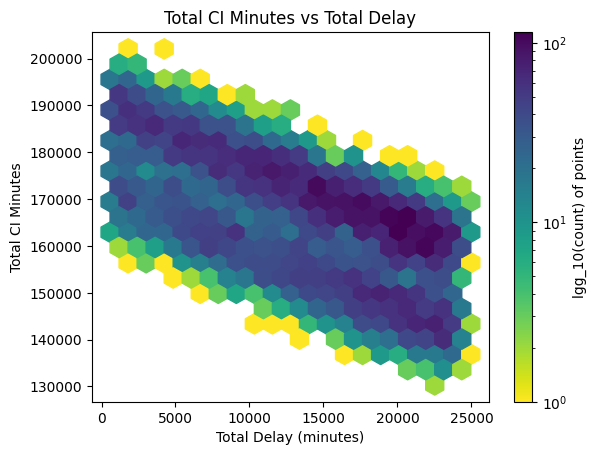

In [43]:
plt.hexbin(
    simulation_results_df["total_delay"],
    simulation_results_df["total_ci_minutes"],
    gridsize=20,
    cmap="viridis_r",
    bins="log",
)

plt.xlabel("Total Delay (minutes)")
plt.ylabel("Total CI Minutes")
plt.title("Total CI Minutes vs Total Delay")
plt.colorbar(label="lgg_10(count) of points")
plt.show()

We expand on this chart further in Artifact 2